In [1]:
!git clone https://github.com/Zigolox/Meta-Learning-OptML-Project
%cd /content/Meta-Learning-OptML-Project

fatal: destination path 'Meta-Learning-OptML-Project' already exists and is not an empty directory.
/content/Meta-Learning-OptML-Project


In [2]:
%%capture
!pip uninstall jax jaxlib -y
!pip install --upgrade "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install --upgrade einops optax equinox jax-tqdm 

In [3]:
import jax

In [4]:
from jax import numpy as jnp
from jax import random, value_and_grad, lax
from optax import adam, sgd, apply_updates, chain, clip, softmax_cross_entropy_with_integer_labels
from einops import rearrange, reduce, repeat
from functools import partial
from tqdm.notebook import tqdm
import equinox as eqx
import tensorflow_datasets as tfds
import tensorflow as tf
from jax.random import split, normal, randint
from jax import lax, vmap, checkpoint
from jax.nn import gelu, sigmoid
from jax import disable_jit
from jax.tree_util import tree_map, tree_leaves

from jax_tqdm import scan_tqdm
from jax import lax
import jax.numpy as jnp

# Typing 
from jax import Array
from typing import Optional, Sequence, Tuple, Any
from jax.random import PRNGKeyArray

SEED = 0
MODEL_KEY = random.PRNGKey(SEED)
TEST_KEY = random.PRNGKey(SEED + 1)
TRAIN_KEY = random.PRNGKey(SEED + 2)
EX_TEST_KEY = random.PRNGKey(SEED + 8)
EX_TRAIN_KEY = random.PRNGKey(SEED + 7)

import copy
import matplotlib.pyplot as plt

In [5]:
def multi_batch_loss(model, batch_loss, batch_of_tasks, inner_step, inner_optim, inner_opt_state) -> Array:
    """Compute the loss over all models"""

    # get model_i', test_i, test_labels_i for all tasks i:
    batch_train, batch_train_labels, batch_test, batch_test_labels = batch_of_tasks
    models = eqx.filter_vmap(inner_step,in_axes=(None,0,0,None,None,None))(model, batch_train, batch_train_labels, batch_loss, inner_optim, inner_opt_state)
    # sum loss_i(model_i', test_i, test_labels_i)
    return eqx.filter_vmap(batch_loss)(models, batch_test, batch_test_labels).sum()

In [6]:
def batch_loss(model, x_arr: Array, labels: Array) -> Array:
    '''Compute the loss.'''

    def loss(x: Array, label: Array):
        # -> (model(x)-Asin(x+w))^2
        pred = model(jnp.array([x]))
        return (pred-label)**2

    # Mean over the batch
    return vmap(loss)(x_arr, labels).mean()

In [7]:
def step(batch_loss, model, train, train_labels, opt_state, optim):
    loss, grad = eqx.filter_value_and_grad(batch_loss)(model, train, train_labels)  # Compute loss and gradient
    updates, opt_state = optim.update(grad, opt_state, model)  # Theta = Theta - alpha*grad(loss)
    model = eqx.apply_updates(model, updates)  # Model = Model(Theta_new)
    return model, opt_state, loss

In [8]:
@partial(eqx.filter_jit)
def outer_step_METASGD(model_alpha, batch_loss, outer_optim, outer_opt_state,
         inner_step, batch_of_tasks, inner_optim, inner_opt_state):
     
    loss, grads = eqx.filter_value_and_grad(multi_batch_loss)(model_alpha, batch_loss, batch_of_tasks, inner_step, inner_optim, inner_opt_state)  # Compute loss and gradient, meta step
    updates, outer_opt_state = outer_optim.update(grads, outer_opt_state, model_alpha)  
    model_alpha = eqx.apply_updates(model_alpha, updates)  

    return loss, model_alpha, outer_opt_state



In [9]:
# Training step function
#@eqx.filter_jit
def inner_step_METASGD(model_alpha, train, train_labels, batch_loss, inner_optim, inner_opt_state):

    model, alpha = copy.deepcopy(model_alpha[0]), model_alpha[1] 

    loss, grad = eqx.filter_value_and_grad(batch_loss)(model, train, train_labels)  # Compute loss and gradient
    mod_grad = tree_map(lambda x,y: x*y, grad, alpha)  # replace standard gradient with alpha*gradient (elementwise product)
    updates, opt_state = inner_optim.update(mod_grad, inner_opt_state, model)  
    model = eqx.apply_updates(model, updates)  

    return model

In [10]:
@partial(eqx.filter_jit)
def outer_step_MAML(model, batch_loss, outer_optim, outer_opt_state,
         inner_step, batch_of_tasks, inner_optim, inner_opt_state):
     
    loss, grads = eqx.filter_value_and_grad(multi_batch_loss)(model, batch_loss, batch_of_tasks, inner_step, inner_optim, inner_opt_state)  # Compute loss and gradient, meta step
    updates, outer_opt_state = outer_optim.update(grads, outer_opt_state, model)  
    model = eqx.apply_updates(model, updates)  

    return loss, model, outer_opt_state

In [11]:
def inner_step_MAML(model, train, train_labels, batch_loss, inner_optim, inner_opt_state):

    model = copy.deepcopy(model)

    model, inner_opt_state, loss = step(batch_loss, model, train, train_labels, inner_opt_state, inner_optim)

    return model

In [12]:
@partial(eqx.filter_jit)
def outer_step_FOMAML(model, batch_loss, outer_optim, outer_opt_state,
         inner_step, batch_of_tasks, inner_optim, inner_opt_state):
    
    batch_train, batch_train_labels, batch_test, batch_test_labels = batch_of_tasks
    models = eqx.filter_vmap(inner_step, in_axes=(None,0,0,None,None,None))(model, batch_train, batch_train_labels, batch_loss, inner_optim, inner_opt_state)
    def multi_batch_loss_fomaml(models, test, test_labels) -> Array:
            """Compute the loss over all models"""
            return eqx.filter_vmap(batch_loss)(models, test, test_labels).sum()
    
    loss, grads = eqx.filter_value_and_grad(multi_batch_loss_fomaml)(models, batch_test, batch_test_labels)  # Compute loss and gradient, meta step
    grad = tree_map(lambda x : x.sum(0),grads)
    updates, outer_opt_state = outer_optim.update(grad, outer_opt_state, model)  
    model = eqx.apply_updates(model, updates)  

    return loss, model, outer_opt_state

In [13]:
def inner_step_FOMAML(model, train, train_labels, batch_loss, inner_optim, inner_opt_state):

    model = copy.deepcopy(model)

    model, inner_opt_state, loss = step(batch_loss, model, train, train_labels, inner_opt_state, inner_optim)  

    return model

In [14]:
@partial(eqx.filter_jit)
def outer_step_REPTILE(model, batch_loss, outer_optim, outer_opt_state,
         inner_step, batch_of_tasks, inner_optim, inner_opt_state, epsilon):
    
    batch_train, batch_train_labels, batch_test, batch_test_labels = batch_of_tasks

    models = eqx.filter_vmap(inner_step, in_axes=(None,0,0,None,None,None))(model, batch_train, batch_train_labels, batch_loss, inner_optim, inner_opt_state)

    model_tilde = tree_map(lambda x: (1/meta_batch_size)*x.sum(0), eqx.filter(models,eqx.is_array))

    dyn_model = tree_map((lambda x,y: x+epsilon*(y-x)), eqx.filter(model,eqx.is_array), eqx.filter(model_tilde,eqx.is_array))
    model = eqx.combine(dyn_model, model)
    
    loss, outer_opt_state = None, None
    return loss, model, outer_opt_state

In [15]:
def inner_step_REPTILE(model, train, train_labels, batch_loss, inner_optim, inner_opt_state, nr_steps=32):

    model = copy.deepcopy(model)

    dynamic_model, static_model = eqx.partition(model, eqx.is_array)
    def scan_step(carry, i):
        dynamic_model, inner_opt_state = carry
        model, inner_opt_state, loss = step(batch_loss, eqx.combine(dynamic_model,static_model), train, train_labels, inner_opt_state, inner_optim)
        return (eqx.partition(model, eqx.is_array)[0], inner_opt_state), loss
    carry = (dynamic_model, inner_opt_state)
    (dynamic_model, inner_opt_state), losses = lax.scan(scan_step,carry,jnp.arange(nr_steps))
    model = eqx.combine(dynamic_model,static_model)  

    return model

In [16]:
# function to load data
@partial(eqx.filter_jit)
def load_batch_of_tasks(nr_train, nr_test, train_key, test_key, test_random=True):  
    A_key, w_key = split(test_key, 2)
    A = random.uniform(train_key, shape=(1,),minval=0.1, maxval=5.0)
    w = random.uniform(train_key, shape=(1,),minval=0.0, maxval=jnp.pi)
    
    train = random.uniform(train_key,shape=(nr_train,),minval=-5.0, maxval=5.0)
    train_labels = jnp.concatenate(list(map(lambda x: A*jnp.sin(x+w), train)))

    if test_random:
        test = random.uniform(test_key,shape=(nr_test,),minval=-5.0, maxval=5.0).sort()
    else:
        test = jnp.linspace(-5, 5, num=nr_test)
    test_labels = jnp.concatenate(list(map(lambda x: A*jnp.sin(x+w), test)))

    return train, train_labels, test, test_labels


In [17]:
def load_task(n_train, n_test, train_key, test_key, A_key, w_key, test_random=True):
    
    A = random.uniform(A_key, shape=(1,),minval=0.1, maxval=5.0)
    w = random.uniform(w_key, shape=(1,),minval=0.0, maxval=jnp.pi)
    
    train = random.uniform(train_key,shape=(n_train,),minval=-5.0, maxval=5.0)
    train_labels = A*jnp.sin(train+w)
    if test_random:
        test = random.uniform(test_key,shape=(n_test,),minval=-5.0, maxval=5.0).sort()
    else:
        test = jnp.linspace(-5, 5, num=n_test)
    test_labels = A*jnp.sin(test+w)

    return (train, train_labels), (test, test_labels)

In [18]:
def help_eval(test_model, test_points, test_labels):
    # evaluation help function
    preds_shot = eqx.filter_vmap(test_model)(jnp.expand_dims(test_points,1))
    preds_shot = rearrange(preds_shot, "a i -> (a i)")
    mse = (jnp.mean(jnp.square(preds_shot-test_labels)))  # mean squared error 
    return mse

In [19]:
def evaluation(model, n_test_train, n_test, train_key, 
                   test_key, inner_step, inner_optim, inner_opt_state, batch_loss):
    # sample N different sine curves 
    N = 100
    M = 100
    sine_keys = split(train_key, N)
    eval_keys = split(test_key, N)
    tot_avg_mse = 0
    for i in range(N):
        # randomly sample a sine curve
        A_key, w_key = split(sine_keys[i], 2)
        # for one sine curve, sample M different training/testing sets
        train_keys = split(eval_keys[i], M)
        batch_from_same_task = eqx.filter_vmap(load_task, in_axes=(None, None, 0, None, None, None, None))(n_test_train, n_test, train_keys, test_key, A_key, w_key, False)
        train_tasks, test_tasks = batch_from_same_task
        batch_trains, batch_trains_labels = train_tasks
        batch_tests, batch_tests_labels = test_tasks
        # train with one inner step
        test_models = eqx.filter_vmap(inner_step,in_axes=(None,0,0,None,None,None))(model, batch_trains, batch_trains_labels, batch_loss, inner_optim, inner_opt_state)
        # average of mean squared errors:
        avg_mse = eqx.filter_vmap(help_eval)(test_models, batch_tests, batch_tests_labels).mean()

        tot_avg_mse += avg_mse
    return tot_avg_mse/N
  

In [20]:
def info_meta_test(expl_model, model, n_test_train, n_test, train_key, 
                   test_key, inner_step, inner_optim, inner_opt_state, batch_loss):

    train_test, train_test_labels, test, test_labels = load_batch_of_tasks(n_test_train,
                                                                           n_test, train_key, test_key, False)

    preds_initial = eqx.filter_vmap(expl_model)(jnp.expand_dims(test,1))

    test_sorted_indices = sorted(range(len(test)), key=lambda k: test[k])

    test_sorted = test[jnp.array(test_sorted_indices)]
    preds_initial_sorted = preds_initial[jnp.array(test_sorted_indices)]
    test_labels_sorted = test_labels[jnp.array(test_sorted_indices)]

    test_model = inner_step(model, train_test, train_test_labels, batch_loss, inner_optim, inner_opt_state)

    preds_shot = eqx.filter_vmap(test_model)(jnp.expand_dims(test_sorted,1))
    preds_shot = rearrange(preds_shot, "a i -> (a i)")

    mse = (jnp.mean(jnp.square(preds_shot-test_labels_sorted)))  # mean squared error 

    pre_init_plt = (test_sorted, preds_initial_sorted)  # pre initialization
    gt_plt = (test_sorted, test_labels_sorted)  # ground truth
    kshot_plt = (test_sorted, preds_shot)  # K-shot learning 
    scatter_points = (train_test, train_test_labels)  # K points  

    return mse, pre_init_plt, gt_plt, kshot_plt, scatter_points

In [21]:
def disp_meta_test(pre_init_plts, gt_plt, kshot_plts, scatter_points, n_train, legends=None, title=''):

    test_sorted, test_labels_sorted = gt_plt
    plt.plot(test_sorted, test_labels_sorted, color='grey', label="Ground Truth", linewidth=4)

    colors = ['b', 'g', 'r', 'c']
    c = 0
    for pre_init_plt in pre_init_plts:
        test_sorted, preds_initial_sorted = pre_init_plt
        if legends is None:
            plt.plot(test_sorted, preds_initial_sorted, color=colors[c], label="Pre initalization", linestyle='dashed', linewidth=1)
        else:
            plt.plot(test_sorted, preds_initial_sorted, color=colors[c], linestyle='dashed', linewidth=1)
        c += 1

    c = 0
    for kshot_plt in kshot_plts:
        test_sorted, preds_shot = kshot_plt
        if legends is None:
            plt.plot(test_sorted, preds_shot, color=colors[c], label=str(n_train)+"-shot learning", linewidth=2)
        else:
            plt.plot(test_sorted, preds_shot, color=colors[c], label=legends[c], linewidth=2)
        c += 1

    train_test, train_test_labels = scatter_points
    plt.scatter(train_test, train_test_labels, color='black',zorder=2)
    plt.legend()
    plt.title(title)
    plt.show()
    return 

In [22]:
epochs = 60000
meta_batch_size = 4 
n_train = 5  # shot training 
n_test = 10  # shot testing 
n_meta_test = 100  # meta evaluation points 
test_keys = random.split(TEST_KEY, epochs)
train_keys = random.split(TRAIN_KEY, epochs)

In [23]:
# META SGD

model = eqx.nn.MLP(1,1,40,2,key=MODEL_KEY)
alpha = copy.deepcopy(eqx.filter(model,eqx.is_array))
init_const = 0.05  # should be between 0.005 and 0.1
alpha = tree_map(lambda x: init_const*jnp.ones(shape=x.shape), alpha)
outer_optim = adam(1e-3)
outer_opt_state = outer_optim.init(eqx.filter((model,alpha), eqx.is_array))  
inner_optim = sgd(1) 
inner_opt_state = inner_optim.init(eqx.filter(model, eqx.is_array))

dynamic_model, static_model = eqx.partition(model, eqx.is_array)

@scan_tqdm(epochs)
def scan_fun(carry,i):
    dynamic_model, alpha, outer_opt_state = carry
    train_keys_batch, test_keys_batch = random.split(train_keys[i], meta_batch_size),  random.split(test_keys[i], meta_batch_size)
    batch_of_tasks = eqx.filter_vmap(load_batch_of_tasks, in_axes=(None, None, 0, 0))(n_train, n_test, train_keys_batch, test_keys_batch)
    loss, (model, alpha), outer_opt_state = outer_step_METASGD((eqx.combine(dynamic_model,static_model), alpha), batch_loss, outer_optim, outer_opt_state,
                                                    inner_step_METASGD, batch_of_tasks, inner_optim, inner_opt_state)
    return (eqx.partition(model, eqx.is_array)[0], alpha, outer_opt_state), loss

carry = (dynamic_model, alpha, outer_opt_state)
(dynamic_model, alpha, outer_opt_state), losses = lax.scan(scan_fun,carry,jnp.arange(epochs))

model = eqx.combine(dynamic_model,static_model)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [24]:
evaluation((model, alpha), n_train, n_meta_test, TRAIN_KEY, 
                   TEST_KEY, inner_step_METASGD, inner_optim, inner_opt_state, batch_loss)

Array(1.3261265, dtype=float32)

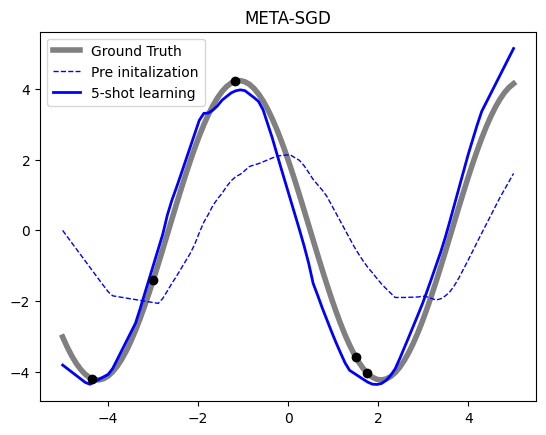

Array(0.3069425, dtype=float32)

In [25]:
mse, pre_init_plt_metasgd, gt_plt, kshot_plt_metasgd, scatter_points = info_meta_test(model,(model, alpha), n_train, n_meta_test, EX_TRAIN_KEY,
                                                                      EX_TEST_KEY, inner_step_METASGD, inner_optim, inner_opt_state, 
                                                                      batch_loss)
disp_meta_test([pre_init_plt_metasgd], gt_plt, [kshot_plt_metasgd], scatter_points, n_train, title="META-SGD")
mse

In [26]:
# MAML

model = eqx.nn.MLP(1,1,40,2,key=MODEL_KEY)
outer_optim = adam(1e-3)
outer_opt_state = outer_optim.init(eqx.filter(model, eqx.is_array))  
inner_optim = sgd(0.01) 
inner_opt_state = inner_optim.init(eqx.filter(model, eqx.is_array))

dynamic_model, static_model = eqx.partition(model, eqx.is_array)

@scan_tqdm(epochs)
def scan_fun(carry,i):
    dynamic_model, outer_opt_state = carry
    train_keys_batch, test_keys_batch = random.split(train_keys[i], meta_batch_size),  random.split(test_keys[i], meta_batch_size)
    batch_of_tasks = eqx.filter_vmap(load_batch_of_tasks, in_axes=(None, None, 0, 0))(n_train, n_test, train_keys_batch, test_keys_batch)
    loss, model, outer_opt_state = outer_step_MAML(eqx.combine(dynamic_model,static_model), batch_loss, outer_optim, outer_opt_state,
                                                    inner_step_MAML, batch_of_tasks, inner_optim, inner_opt_state)
    return (eqx.partition(model, eqx.is_array)[0], outer_opt_state), loss

carry = (dynamic_model, outer_opt_state)
(dynamic_model, outer_opt_state), losses = lax.scan(scan_fun,carry,jnp.arange(epochs))

model = eqx.combine(dynamic_model,static_model)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [27]:
evaluation(model, n_train, n_meta_test, TRAIN_KEY, 
                   TEST_KEY, inner_step_MAML, inner_optim, inner_opt_state, batch_loss)

Array(1.3867679, dtype=float32)

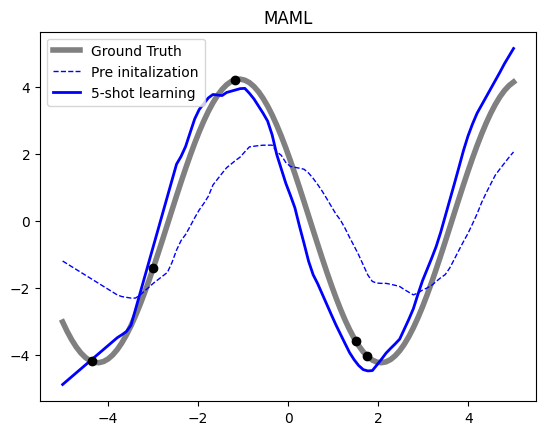

Array(0.5352239, dtype=float32)

In [28]:
mse, pre_init_plt_maml, gt_plt, kshot_plt_maml, scatter_points = info_meta_test(model, model, n_train, n_meta_test, EX_TRAIN_KEY,
                                                                      EX_TEST_KEY, inner_step_MAML, inner_optim, inner_opt_state, 
                                                                      batch_loss)
disp_meta_test([pre_init_plt_maml], gt_plt, [kshot_plt_maml], scatter_points, n_train, title="MAML")
mse

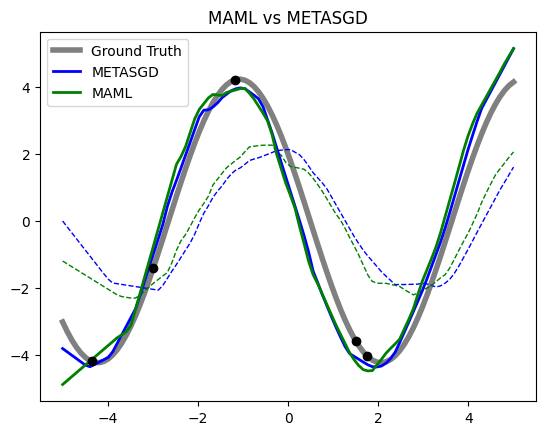

In [29]:
# plot META-SGD and MAML together 
disp_meta_test([pre_init_plt_metasgd, pre_init_plt_maml], gt_plt, [kshot_plt_metasgd, kshot_plt_maml],
               scatter_points, n_train, legends=['METASGD', 'MAML'], title="MAML vs METASGD")

In [30]:
# FOMAML

model = eqx.nn.MLP(1,1,40,2,key=MODEL_KEY)
outer_optim = adam(1e-3)
outer_opt_state = outer_optim.init(eqx.filter(model, eqx.is_array)) 
inner_optim = sgd(0.01) 
inner_opt_state = inner_optim.init(eqx.filter(model, eqx.is_array))

dynamic_model, static_model = eqx.partition(model, eqx.is_array)

@scan_tqdm(epochs)
def scan_fun(carry,i):
    dynamic_model, outer_opt_state = carry
    train_keys_batch, test_keys_batch = random.split(train_keys[i], meta_batch_size),  random.split(test_keys[i], meta_batch_size)
    batch_of_tasks = eqx.filter_vmap(load_batch_of_tasks, in_axes=(None, None, 0, 0))(n_train, n_test, train_keys_batch, test_keys_batch)
    loss, model, outer_opt_state = outer_step_FOMAML(eqx.combine(dynamic_model,static_model), batch_loss, outer_optim, outer_opt_state,
                                                    inner_step_FOMAML, batch_of_tasks, inner_optim, inner_opt_state)
    return (eqx.partition(model, eqx.is_array)[0], outer_opt_state), loss

carry = (dynamic_model, outer_opt_state)
(dynamic_model, outer_opt_state), losses = lax.scan(scan_fun,carry,jnp.arange(epochs))

model = eqx.combine(dynamic_model,static_model)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [31]:
evaluation(model, n_train, n_meta_test, TRAIN_KEY, 
                   TEST_KEY, inner_step_FOMAML, inner_optim, inner_opt_state, batch_loss)

Array(1.2793216, dtype=float32)

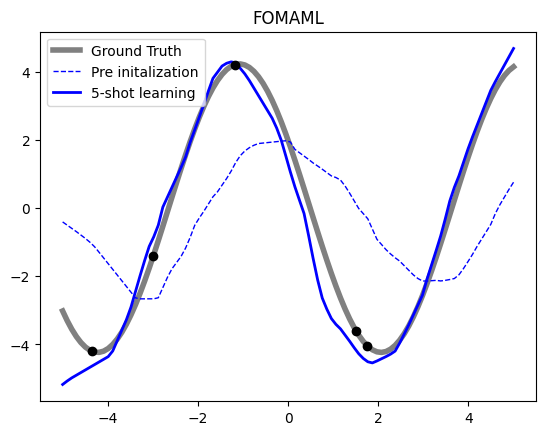

Array(0.37203583, dtype=float32)

In [32]:
mse, pre_init_plt_fomaml, gt_plt, kshot_plt_fomaml, scatter_points = info_meta_test(model, model, n_train, n_meta_test, EX_TRAIN_KEY,
                                                                      EX_TEST_KEY, inner_step_FOMAML, inner_optim, inner_opt_state, 
                                                                      batch_loss)
disp_meta_test([pre_init_plt_fomaml], gt_plt, [kshot_plt_fomaml], scatter_points, n_train, title="FOMAML")
mse

In [33]:
# REPTILE
epochs = 60000

model = eqx.nn.MLP(1,1,64,2,key=MODEL_KEY)
outer_optim = None
outer_opt_state = None
inner_optim = adam(1e-3) 
inner_opt_state = inner_optim.init(eqx.filter(model, eqx.is_array))
epsilon = 0.01

dynamic_model, static_model = eqx.partition(model, eqx.is_array)

@scan_tqdm(epochs)
def scan_fun(carry,i):
    dynamic_model, outer_opt_state = carry
    train_keys_batch, test_keys_batch = random.split(train_keys[i], meta_batch_size),  random.split(test_keys[i], meta_batch_size)
    batch_of_tasks = eqx.filter_vmap(load_batch_of_tasks, in_axes=(None, None, 0, 0))(n_train, n_test, train_keys_batch, test_keys_batch)
    loss, model, outer_opt_state = outer_step_REPTILE(eqx.combine(dynamic_model,static_model), batch_loss, outer_optim, outer_opt_state,
                                                    inner_step_REPTILE, batch_of_tasks,inner_optim, inner_opt_state, epsilon)
    return (eqx.partition(model, eqx.is_array)[0], outer_opt_state), loss

carry = (dynamic_model, outer_opt_state)
(dynamic_model, outer_opt_state), losses = lax.scan(scan_fun,carry,jnp.arange(epochs))

model = eqx.combine(dynamic_model,static_model)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [34]:
evaluation(model, n_train, n_meta_test, TRAIN_KEY, 
                   TEST_KEY, inner_step_REPTILE, inner_optim, inner_opt_state, batch_loss)

Array(2.3314555, dtype=float32)

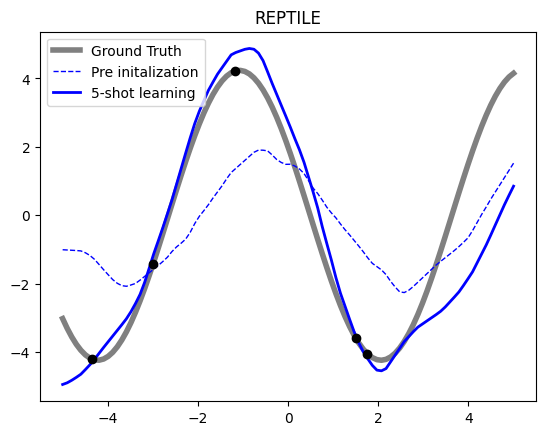

Array(2.1288865, dtype=float32)

In [35]:
mse, pre_init_plt_reptile, gt_plt, kshot_plt_reptile, scatter_points = info_meta_test(model, model, n_train, n_meta_test, EX_TRAIN_KEY,
                                                                      EX_TEST_KEY, inner_step_REPTILE, inner_optim, inner_opt_state, 
                                                                      batch_loss)
disp_meta_test([pre_init_plt_reptile], gt_plt, [kshot_plt_reptile], scatter_points, n_train, title="REPTILE")
mse